In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Go to Python folder to import routines


Current directory:  C:\Users\Thomas\OneDrive\Bureau\Data_article_2024\Olivia
Python folders:  ['EffectiveMedia', 'Fluid', 'Hydro', 'Utils']


In [45]:
# Path


Path_to_save_model = r'C:\Users\Thomas\OneDrive\Documents\GitHub\Supplementary_2024\Essaie_model/'
dvR_Path=r'C:\Users\Thomas\OneDrive\Bureau\Data_article_2024\dv/'
MVG=r'C:\Users\Thomas\OneDrive\Bureau\Data_article_2024\modele_vitesse/'
Sat=r'C:\Users\Thomas\OneDrive\Bureau\Data_article_2024\Hydro/'
if os.getcwd() != r'C:\Users\Thomas\OneDrive\Bureau\Data_article_2024\Olivia': 
    os.chdir(r'C:\Users\Thomas\OneDrive\Bureau\Data_article_2024\Olivia')
    

print('Current directory: ', os.getcwd())
print('Python folders: ', [x for x in os.listdir() if '.' not in x])
# Import routines
from EffectiveMedia.GranularModels import Walton_modified
from Fluid.Gassmann import isoGassmann, fluidWood
from Hydro.hydro_models import Swe_from_wt_VG
from Utils.bounds import HillAvr
from Utils.elastic_param import Vp_from_K_G, Vs_from_G

Current directory:  C:\Users\Thomas\OneDrive\Bureau\Data_article_2024\Olivia
Python folders:  ['EffectiveMedia', 'Fluid', 'Hydro', 'Utils']


In [2]:

def __Swe(Sw,Swr):
    return((Sw-Swr)/(1-Swr))
def __Swe(Sw,Swr):
    return((Sw-Swr)/(1-Swr))
# Routine stair_case
def __function_staircase(depth,Vp,Vs,Rho,time): # permet de faire une fonction escalier type modèle de vitesse
    # Vp est un vecteur
    # Vs est un vecteur
    # Rho est une matrice
    # time est l'index de temps correspondant pour le modèle
    x=[]
    y=[]
    for i in range(depth.size-1):
        X=np.zeros(2)
        Y=np.zeros(2)
        X[:]=Vs_refz[i][time]
        Y[0]=depth[i]
        Y[1]=depth[i+1]
        x.append(X)
        y.append(Y)
    x=np.asarray(x)
    y=np.asarray(y)
    x=np.asarray(x).reshape(x.size)
    y=np.asarray(y).reshape(y.size)
    dVs=np.asarray(x)
    dVsdepth=np.asarray(y)
    x=[]
    y=[]
    for i in range(depth.size-1):
        X=np.zeros(2)
        Y=np.zeros(2)
        X[:]=Vp_refz[i][time]
        Y[0]=depth[i]
        Y[1]=depth[i+1]
        x.append(X)
        y.append(Y)
    x=np.asarray(x)
    y=np.asarray(y)
    x=np.asarray(x).reshape(x.size)
    y=np.asarray(y).reshape(y.size)
    dVp=np.asarray(x)
    dVpdepth=np.asarray(y)
    x=[]
    y=[]
    for i in range(depth.size-1):
        X=np.zeros(2)
        Y=np.zeros(2)
        X[:]=Rho[i,time]
        Y[0]=depth[i]
        Y[1]=depth[i+1]
        x.append(X)
        y.append(Y)
    x=np.asarray(x)
    y=np.asarray(y)
    x=np.asarray(x).reshape(x.size)
    y=np.asarray(y).reshape(y.size)
    dVrho=np.asarray(x)
    dVrhodepth=np.asarray(y)
    return(dVp,dVs,dVrho,dVrhodepth)
dc_data=np.loadtxt(MVG+'/vitesse400.txt')
dc_data=np.asarray(dc_data)
v=dc_data[:,1]
times=dc_data[:,0].astype('int')

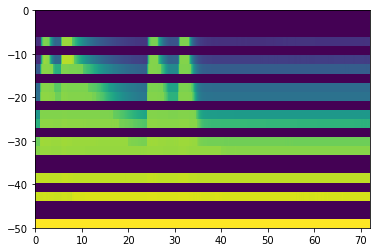

In [38]:
New_Depth=-np.arange(2,50,2)
Sw, Pw, Pf, depth = np.load(rf'{Sat}/Saturation_Pw_Pf_depth.npy',allow_pickle=True)
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
Sw_new=np.zeros((New_Depth.size,Sw[0].size))
for i in range(depth.size):
    idx=find_nearest(New_Depth,depth[i])
    Sw_new[idx]=Sw[i]
SS=Sw_new.copy()
plt.imshow(Sw_new,aspect='auto',extent=[0,72,-50,0])    
Sw_new[0]=Sw_new[4]
Sw_new[1]=Sw_new[4]
Sw_new[2]=Sw_new[4]
Sw_new[3]=Sw_new[4]
Sw_new[4]=Sw_new[4]

for i in range(25920):
    y = Sw[:,i]
    x = depth
    z = np.polyfit(x, y, 4)
    p = np.poly1d(z)
    j=p(New_Depth)
    Sw_new[:,i]=j

### Saturation extrapolation between - 9 and 0     
Sw_new[0]=Sw_new[4]
Sw_new[1]=Sw_new[4]
Sw_new[2]=Sw_new[4]
Sw_new[3]=Sw_new[4]

In [39]:
coeff_corr=0
Pf_depth=27+ coeff_corr     # Depth of Pf measurement
Pz_depth=52#   + coeff_corr    # Depth of Pz measurement
L_sand=58         # Sand width
correct=[]
Save_Option = True
for i in range(New_Depth.size):
    Sw, Pw, Pf, depth = np.load(rf'{Sat}/Saturation_Pw_Pf_depth.npy',allow_pickle=True)
    Sw=Sw_new
    depth=New_Depth#+ coeff_corr+1
    #depth-=coeff_corr
    Pw = Pw*1e-1 # kPa
    Pf = Pf*1e-1 # kPa
    PzR_depth=abs(depth[i])      # Depth of Pr_R to be recovered
    PiezoRef='Pz'
    # Compute Pw, the recovered pressur at depth z
    if PiezoRef=="Pz":
        i_piezo = np.argmax(abs(depth))#np.where(depth==np)[0][0] # indice de prof équivalent Pz/Sw, 48 etant le plus proche de 50
        Pw_z=Pw-0.098064*(Pz_depth-PzR_depth) # Calcul de la pression à la profondeur z à partir de Pz

    i_piezof =find_nearest(depth, -Pf_depth) #np.where(depth==-Pf_depth)[0][0] # indice de prof équivalent Pf/Sw
    i_piezoR =find_nearest(depth, -PzR_depth) #np.where(depth==-PzR_depth)[0][0] # indice de prof équivalent Pz/Sw
    #print(i_piezoR,PzR_depth)

    #i_piezof = np.where(depth==-Pf_depth)[0][0] # indice de prof équivalent Pf/Sw
    SwPf = Sw[i_piezof,:]
    SwR = Sw[i_piezoR,:]
    # Check hydrostatic values for depth=28cm and depth=54cm
    rho_w = 1.0*1e3            # water density (kg/m3)
    g = 9.806                  # Earth’s gravitational acceleration (m.s^-2)
    z = np.array([Pf_depth,Pz_depth])*1e-2 # depth (m)
    Phydro = rho_w*g*z*1e-3    # computed hydrostatic pressure (kPa)
    # Mineral properties
    K_Qz = 44      #GPa (Barriere et al., GJI 2012) Shear Modulus solid
    G_Qz = 36      #GPa (Barriere et al., GJI 2012) Bulk Modulus solid
    rho_Qz = 2.65  #g/cc (Barriere et al., GJI 2012) density of quartz
    K_Ka = 1.5     #GPa  Bulk Modulus gaz
    G_Ka = 1.4     #GPa  Shear gaz
    rho_Ka = 1.58  #g/cc 1.58
    f_Qz = 1.0     #unitless 1.0

    # Fluid properties
    Kw = 2.5     #GPa 2.3 Barriere 
    rho_w = 1.0  #g/cc 1.0
    Ka = 1e-4    #GPa 1e-4
    rho_a = 1e-3 #g/cc 1e-3

    # Rock matrix properties
    phi = 0.4 #Porosity - measured (Barriere et al., GJI 2012)
    phi_0=0.38
    C0 = 6      #Coordination number in the high stress limit - Landes Sand (Barriere et al., GJI 2012)
    R = 2/5     #Walton friction parameter (Barriere et al., GJI 2012)
    P0 = 22     #Critical pressure for modified Walton model (MPa) - (Barriere et al., GJI 2012)
    Swr = 0.1  #Residual water saturation (to confirm with Thomas)
    Ks = HillAvr(K_Qz, f_Qz, K_Ka)        #GPa
    Gs = HillAvr(G_Qz, f_Qz, G_Ka)        #GPa
    rho_s = rho_Qz*f_Qz + (1-f_Qz)*rho_Ka #g/cc
    rho_f = SwR*rho_w + (1-SwR)*rho_a  #g/cc (fluid density at piezometer level) # Control Vs
    rho_f_full = Sw*rho_w + (1-Sw)*rho_a #g/cc
    Kf = fluidWood(SwR, Kw, Ka)         #GPa
    # Bulk density
    rho_sat = rho_s*(1-phi) + rho_f_full[i_piezof,:]*phi        #g/cc (fluid density at piezometer level)
    rho_satR = rho_s*(1-phi) + rho_f_full[i_piezoR,:]*phi        #g/cc (fluid density at piezometer level)
    rho_sat_full = rho_s*(1-phi) + rho_f_full*phi #g/cc 
    P=np.zeros([len(depth), Sw[0].size]) # matrice utilisée pour la pression de confirnement (overburden stress)
    prod_rhoDepth_min = np.zeros(np.shape(Sw))
    for i_depth in range(New_Depth.size):
        if i_depth == 0 :
            prod_rhoDepth_min[i_depth,:] = rho_sat_full[i_depth,:]*1e3*abs(depth[i_depth]-0)*1e-2  
            #print(depth[i_depth])
            P[i_depth,:]= prod_rhoDepth_min[i_depth,:]*g*1e-6
        else :
            prod_rhoDepth_min[i_depth,:] = rho_sat_full[i_depth,:]*1e3*abs(depth[i_depth]-depth[i_depth-1])*1e-2  #  * dz
            #prod_rhoDepth_min[i_depth,:] = rho_sat_full[i_depth,:]*1e3*abs(depth[i_depth])*1e-2  #  * dz

            P[i_depth,:]=np.sum(prod_rhoDepth_min[0:i_depth,:],axis=0)*g*1e-6 + P[0,:]

    # Effective pressure
    #-- Test Peff = P - Pf
    Peff = P[i_piezof,:] - Pf*1e-3  # effective pressure (MPa) Terzaghi @ 27cm (Peff=sigma-Pf)
    Peff2 = P[i_piezoR,:]  -__Swe(Sw[i_depth],Swr)*Pw_z*1e-3# effective pressure (MPa) used for the simple fluid substitution
    Peff_z = P[i_piezoR,:] - Pw_z*1e-3  # effective pressure (MPa) recovered at depth z # Il faut casser cette valeur par 3 pour tendre
    #Peff_z=(1-phi)*(rho_Qz-np.sum(Sw_new[0:i_depth])*1)*g*(abs(depth[i_depth]*10**-2))*1e-3
    #Peff_z=(1-phi)*(rho_Qz-np.sum(Sw_new[0:i_depth],0)/i_depth*1)*g*(abs(depth[i_depth]*10**-2))*1e-3

    # Vers des Vs acceptable.
    # Drained properties
    ### içi.
    Kdr, Gdr = Walton_modified(Ks, Gs, Peff, P0, phi=phi_0, C0=C0, R=R); # Biot-Gassman + Walton avec Pf
    Kdr2, Gdr2 = Walton_modified(Ks, Gs, Peff2, P0, phi=phi_0, C0=C0, R=R) # Biot Gassman substitution de fluide sans Pf
    Kdrz, Gdrz = Walton_modified(Ks, Gs, Peff_z, P0, phi=phi_0, C0=C0, R=R)# Biot-Gassman + Walton avec Pf recovered @ z
    # Saturated properties
    Ksat = isoGassmann(Kdr, Gdr, Ks, Kf, phi)
    Vp_sat = Vp_from_K_G(Ksat, Gdr, rho_sat)
    Vs_sat = Vs_from_G(Gdr, rho_sat)
    Ksat2 = isoGassmann(Kdr2[len(Kdr2)-10], Gdr2[len(Kdr2)-10], Ks, Kf, phi)
    Vp_sat2= Vp_from_K_G(Ksat2, Gdr2, rho_satR)
    Vs_sat2 = Vs_from_G(Gdr2, rho_satR)
    Ksatz = isoGassmann(Kdrz[len(Kdrz)-10], Gdrz[len(Kdrz)-10], Ks, Kf, phi) ### Pourquoi - 10? -- On s'en fou
    Vp_satz= Vp_from_K_G(Ksatz, Gdrz, rho_satR)
    Vs_satz = Vs_from_G(Gdrz, rho_satR)
    # Reference velocities (same as Thomas, avg of velocities between 2300 and 3000 min)
    t_ref1 = int(2300*60/10)
    t_ref2 = int(3000*60/10)
    Vp_ref = np.nanmean(Vp_sat[t_ref1:t_ref2]); #print('Vp_ref = {:.1f} m/s'.format(Vp_ref*1e3))
    Vs_ref = np.nanmean(Vs_sat[t_ref1:t_ref2]); #print('Vs_ref = {:.1f} m/s'.format(Vs_ref*1e3))
    Vp_ref2 = np.nanmean(Vp_sat2[t_ref1:t_ref2]); #print('Vp_ref2 = {:.1f} m/s'.format(Vp_ref2*1e3))
    Vs_ref2 = np.nanmean(Vs_sat2[t_ref1:t_ref2]); #print('Vs_ref2 = {:.1f} m/s'.format(Vs_ref2*1e3))
    Vp_refz = np.nanmean(Vp_satz[t_ref1:t_ref2]); #print('Vp_refz = {:.1f} m/s'.format(Vp_refz*1e3))
    Vs_refz = np.nanmean(Vs_satz[t_ref1:t_ref2]); #print('Vs_refz = {:.1f} m/s'.format(Vs_refz*1e3))
    #Biot-Gassman
    Kfr=0.02 # Frame modulus
    Gfr=0.0154 # shear frame modulus
    KsatB= isoGassmann(Kfr, Gfr, Ks, Kf, phi)
    Vp_satB=Vp_from_K_G(KsatB,Gfr,rho_satR)
    Vs_satB = Vs_from_G(Gfr, rho_satR)
    Vp_refB = np.mean(Vp_satB[t_ref1:t_ref2]); #print('Vp_refB = {:.1f} m/s'.format(Vp_refB*1e3))
    Vs_refB = np.mean(Vs_satB[t_ref1:t_ref2]); #print('Vs_refB = {:.1f} m/s'.format(Vs_refB*1e3))
    #### Uncomment for saving Model
    if Save_Option:
        Folder_Name = rf'Phi_{phi}_C0_{C0}_R_{R}_P0_{P0}'
        directory = Path_to_save_model+'/'+Folder_Name
        if not os.path.exists(directory):
            os.makedirs(directory)
        np.save(directory+rf'/Test_Modeling_petro_{phi}1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}__piezo_depth_{Pz_depth}_add_BG',
                [Vp_sat,Vs_sat,Vp_sat2,Vs_sat2,Vp_satz,Vs_satz,Vp_refB,Vs_refB,Vs_satB,rho_sat_full,Peff_z])
    #np.save(rf'C:\Hydro_modele\dv_compute\roflTest_Modeling_petro_{phi}1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}__piezo_depth_{Pz_depth}_add_BG',[Vp_sat,Vs_sat,Vp_sat2,Vs_sat2,Vp_satz,Vs_satz,Vp_refB,Vs_refB,Vs_satB,rho_sat_full,Peff_z])

In [33]:
Pz_depth

52

In [46]:
Vp=[]
Vs=[]
Vp_ref2=[]
Vs_ref2=[]
Vp_refz=[]
Vs_refz=[]
t_ref1 = int(2300*60/10)
t_ref2 = int(3000*60/10)
Vp0=[]
Vs0=[]
Vp1=[]
Vs1=[]
Vp2=[]
Vs2=[]
Vb=[]
Vbref=[]
corr=+0
Peff=[]
Rho=[]
Modelling_path= Path_to_save_model+'/'+Folder_Name
os.chdir(Modelling_path)
for i in range(New_Depth.size):
    #data=np.load(rf'C:\Hydro_modele\dv_compute\{abs(depth[i])+corr}_Pz.npy')
    PzR_depth=abs(New_Depth[i])
    data=np.load(rf'Test_Modeling_petro_{phi}1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}__piezo_depth_{Pz_depth}_add_BG.npy',
                 allow_pickle=True)
    #data=np.load(rf'C:\Hydro_modele\dv_compute\Test_Modeling_petro_{phi}1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}__piezo_depth_{Pz_depth}_add_BG.npy')
    ##data=np.load(rf'C:\Users\Thomas\OneDrive\Bureau\Data_article_2024\Modèle\Test_Modeling_petro_0.41_cmInterp_SwPf_Phi_0v2_{PzR_depth}_Pz__piezo_depth_52_add_BG.npy',allow_pickle=True)
    #data=np.load(rf'C:\Hydro_modele\dv_compute\Modeling_petro_{phi}1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}_add_BG.npy',allow_pickle=True)
    #1_cmInterp_SwPf_Phi_0v2_{PzR_depth}_{PiezoRef}_add_BG.npy',allow_pickle=True)
    Vp.append(data[0])
    Vs.append(data[1])
    Vp_ref2.append(data[2])
    Vs_ref2.append(data[3])
    Vp_refz.append(data[4])
    Vs_refz.append(data[5])
    Vb.append(data[8])
    Vp0.append(np.nanmean(data[0][t_ref1:t_ref2]))
    Vs0.append(np.nanmean(data[1][t_ref1:t_ref2]))
    Vp1.append(np.nanmean(data[2][t_ref1:t_ref2]))
    Vs1.append(np.nanmean(data[3][t_ref1:t_ref2]))
    Vp2.append(np.nanmean(data[4][t_ref1:t_ref2]))
    Vs2.append(np.nanmean(data[5][t_ref1:t_ref2]))
    Vbref.append(np.nanmean(data[8][t_ref1:t_ref2]))
    Peff.append(data[-1])
    Rho.append(data[-2])
print(len(Vs0))
dvp=[]
dvs=[]
dvp1=[]
dvs1=[]
dvp2=[]
dvs2=[]
dvGBW=[]
for i in range(New_Depth.size):
    dvp.append((Vp[i]-Vp0[i])/Vp0[i]*1e2)
    dvs.append((Vs[i]-Vs0[i])/Vs0[i]*1e2)
    dvp1.append((Vp_ref2[i]-Vp1[i])/Vp1[i]*1e2)
    dvs1.append((Vs_ref2[i]-Vs1[i])/Vs1[i]*1e2)
    dvp2.append((Vp_refz[i]-Vp2[i])/Vp2[i]*1e2)
    dvs2.append((Vs_refz[i]-Vs2[i])/Vs2[i]*1e2)
    dvGBW.append((Vb[i]-Vbref[i])/Vb[i]*1e2)
dvR=np.load(rf'{dvR_Path}\dv_median.npy')
tT=np.linspace(0,72*60,dvR.size)
t = tT
#plt.savefig('F:\Fig_to_make/depth_model.pdf',format='pdf',bbox_inches='tight',dpi=300)
#plt.savefig('F:\Fig_to_make/depth_model.jpg',format='jpg',bbox_inches='tight',dpi=300)



24


C:\Users\Thomas\Anaconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:122: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


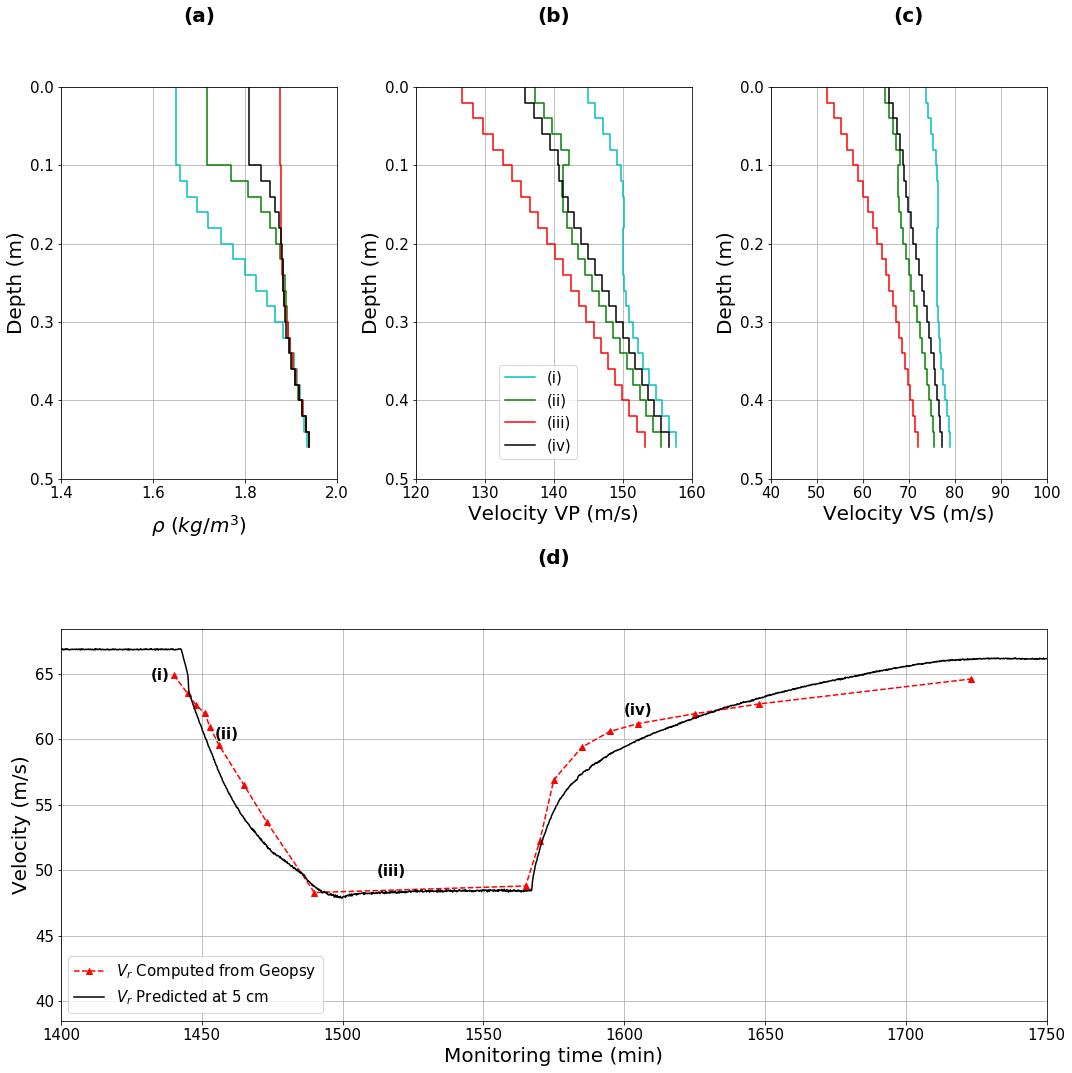

In [47]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
New_Depth=-np.arange(0,48,2)

fig = plt.figure(figsize=(15,15),constrained_layout=True)
gs = gridspec.GridSpec(4, 3)
ax3 = plt.subplot(gs[0:2,0])
ax2 = plt.subplot(gs[0:2, 1])
ax1 = plt.subplot(gs[0:2, 2])
ax5 = plt.subplot(gs[2::, :])
ax1.grid()
ax2.grid()
ax3.grid()

dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],times[0]*6)
prof=prof*10**-2
ax1.plot(dvS*1000,prof,'c',label='Vs 1440 minutes')
ax2.plot(dvP*1000,prof,'c',label='(i)')
ax3.plot(dvRho,prof,'c',label=r'$\rho$ 1440 minutes')


dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],times[4]*6)
prof=prof*10**-2
dvP=np.concatenate((np.asarray([dvP[0]]),dvP))
dvS=np.concatenate((np.asarray([dvS[0]]),dvS))
dvRho=np.concatenate((np.asarray([dvRho[0]]),dvRho))
prof=np.concatenate((np.asarray([0]),prof))
ax1.plot(dvS*1000,prof,'g',label='Vs 1453 minutes')
ax2.plot(dvP*1000,prof,'g',label='(ii)')
ax3.plot(dvRho,prof,'g',label=r'$\rho$ 1453 minutes')


dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],1530*6)
prof=prof*10**-2
dvP=np.concatenate((np.asarray([dvP[0]]),dvP))
dvS=np.concatenate((np.asarray([dvS[0]]),dvS))
dvRho=np.concatenate((np.asarray([dvRho[0]]),dvRho))
prof=np.concatenate((np.asarray([0]),prof))
ax1.plot(dvS*1000,prof,'r',label='Vs 1530 minutes')
ax2.plot(dvP*1000,prof,'r',label='(iii)')
ax3.plot(dvRho,prof,'r',label=r'$\rho$ 1530 minutes')

dvP,dvS,dvRho,prof=__function_staircase(-New_Depth,Vp_refz,Vs_refz,Rho[0],times[14]*6)
prof=prof*10**-2
dvP=np.concatenate((np.asarray([dvP[0]]),dvP))
dvS=np.concatenate((np.asarray([dvS[0]]),dvS))
dvRho=np.concatenate((np.asarray([dvRho[0]]),dvRho))
prof=np.concatenate((np.asarray([0]),prof))
ax1.plot(dvS*1000,prof,'k',label='Vs 1605 minutes')
ax2.plot(dvP*1000,prof,'k',label='(iv)')
ax3.plot(dvRho,prof,'k',label=r'$\rho$ 1605 minutes')





tT=np.linspace(0,72*60,Vs_refz[0].size)
ax5.plot(times,v,'^r--', label=f'$V_r$ Computed from Geopsy')
ax5.plot(tT,0.9*1000*Vs_refz[1],'k',label='$V_r$ Predicted at 5 cm')
ax5.set_xlim(1400,1750)
ax5.legend(fontsize=15)
ax5.grid()
ax5.set_ylabel('Velocity (m/s)',fontsize=20)
ax5.set_xlabel('Monitoring time (min)',fontsize=20)

ax5.annotate(r'(i)', (1450, 60),
            xytext=(0.11, 0.9), textcoords='axes fraction',fontweight="bold",
            ha="right", va="top",      
            fontsize=15,
            horizontalalignment='right', verticalalignment='top')
ax5.annotate(r'(ii)', (1453, 60),
            xytext=(0.18, 0.75), textcoords='axes fraction',fontweight="bold",
            ha="right", va="top",      
            fontsize=15,
            horizontalalignment='right', verticalalignment='top')

ax5.annotate(r'(iii)', (1453, 60),
            xytext=(0.35, 0.4), textcoords='axes fraction',fontweight="bold",
            ha="right", va="top",      
            fontsize=15,
            horizontalalignment='right', verticalalignment='top')

ax5.annotate(r'(iv)', (1453, 60),
            xytext=(0.6, 0.81), textcoords='axes fraction',fontweight="bold",
            ha="right", va="top",      
            fontsize=15,
            horizontalalignment='right', verticalalignment='top')

ax5.tick_params(axis='both', which='major', labelsize=15)




ax3.set_xlim(1.4,2)
ax3.set_xlabel(r'$\rho \ (kg/m^3)$',fontsize=20,labelpad=12)
ax1.set_xlabel('Velocity VS (m/s)',fontsize=20)
ax2.set_xlabel('Velocity VP (m/s)',fontsize=20)
ax1.set_ylabel('Depth (m)',fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.set_ylabel('Depth (m)',fontsize = 20)
ax3.set_ylabel('Depth (m)',fontsize = 20)

ax2.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlim(120,160)
ax1.set_xlim(40,100)

#ax3.legend(loc=(0.0,0.05),fontsize=15)
#ax1.legend(loc=(0.32,0.05),fontsize=15)
ax2.legend(loc=(0.30,0.05),fontsize=15)

ax1.set_ylim(0.5,0)
ax2.set_ylim(0.5,0)
ax3.set_ylim(0.5,0)
ax1.set_title('(c)',fontsize=20,y=1.15,fontweight="bold")
ax2.set_title('(b)',fontsize=20,y=1.15,fontweight="bold")
ax3.set_title('(a)',fontsize=20,y=1.15,fontweight="bold")
ax5.set_title('(d)',fontsize=20,y=1.15,fontweight="bold")
fig.tight_layout()


C:\Users\Thomas\Anaconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:71: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


<Figure size 1080x1080 with 0 Axes>

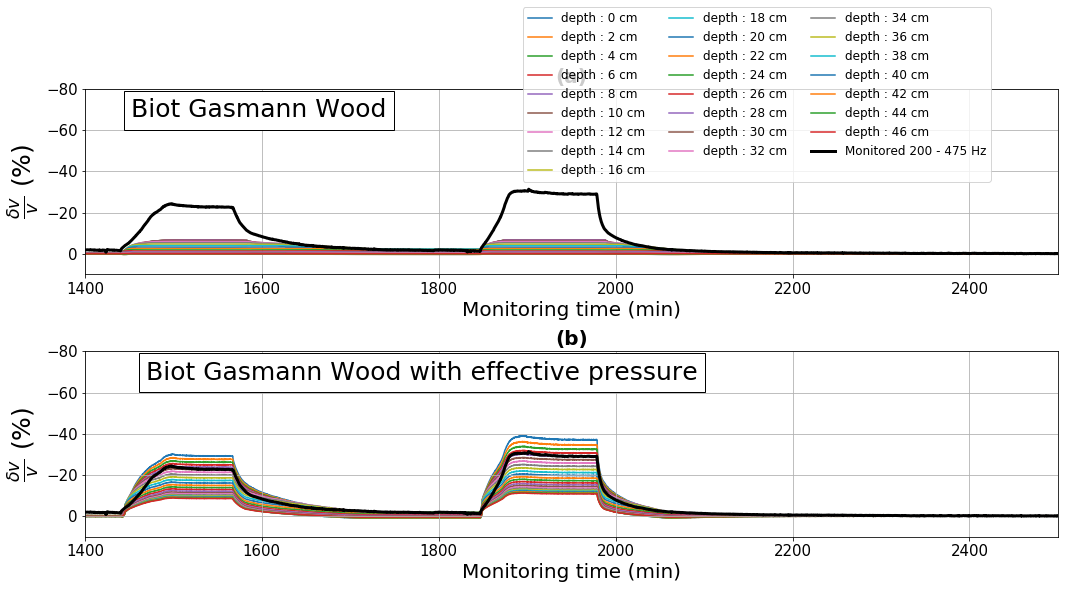

In [36]:
tT=np.linspace(0,72*60,dvR.size)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15,15),constrained_layout=True)
C=['(a)','(b)']
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(15,15),constrained_layout=True)
gs = gridspec.GridSpec(4, 4)

ax4 = plt.subplot(gs[0, :])
ax1 = plt.subplot(gs[1, :])
ax=ax1
data=[]
for i in range(0,New_Depth.size):#depth.size-1):
    ax.plot(tT,dvs2[i],label=f'Depth : {abs(New_Depth[i])} cm',zorder=1)
    data.append(dvs2[i])
ax.plot(tT,dvR,'black',label=f'Monitored {200} - {475} Hz',linewidth=3,zorder=2)
ax.set_xlim(1400,2500)
ax.set_xlabel('Monitoring time (min)',fontsize=20)
ax.set_ylabel(r'$\delta v$ (%)',fontsize=20)
ax.grid()
ax.set(xlabel='Monitoring time (min)', xlim=[1400,2500],
       ylabel=r'$\frac{\delta v}{v}$ (%)', ylim=[-80,10])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_ylabel(r'$\frac{\delta v}{v}$ (%)',fontsize=25)
ax.set_ylim(10,-80)
ax.annotate(r'Biot Gasmann Wood with effective pressure', (1400, -70),
            xytext=(0.63, 0.95), textcoords='axes fraction',
            ha="right", va="top",
            bbox=dict(boxstyle="square",
                   ec=(0., 0, 0),
                   fc=(1., 1, 1),
                   )    ,        
            fontsize=25,
            horizontalalignment='right', verticalalignment='top')
ax.set_title('(b)',fontsize=20,y=1,fontweight="bold")

ax=ax4
for i in range(0,New_Depth.size):#depth.size-1):
    ax.plot(tT,dvGBW[i],label=f'depth : {abs(New_Depth[i])} cm')

ax.plot(tT,dvR,'k',label=f'Monitored {200} - {475} Hz',linewidth=3,zorder=2)
ax.set_xlim(1400,2500)
#ax.legend(fontsize=12,loc=(0.7,0.15))
ax.grid()
ax.set(xlabel='Monitoring time (min)', xlim=[1400,2500],
       ylabel=r'$\delta v$ (%)', ylim=[-80,10])
ax.set_xlabel('Monitoring time (min)',fontsize=20)
ax.set_ylabel(r'$\frac{\delta v}{v}$ (%)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_title('(a)',fontsize=20,y=1,fontweight="bold")
ax.set_ylabel(r'$\frac{\delta v}{v}$ (%)',fontsize=25)
ax.set_ylim(10,-80)
ax.annotate(r'Biot Gasmann Wood', (1400, -70),
            xytext=(0.31, 0.95), textcoords='axes fraction',
            ha="right", va="top",
            bbox=dict(boxstyle="square",
                   ec=(0., 0, 0),
                   fc=(1., 1, 1),
                   )    ,        
            fontsize=25,
            horizontalalignment='right', verticalalignment='top')
ax.legend(fontsize=12,loc=(0.45,0.5),ncol=3)

fig.tight_layout()

#plt.savefig('F:\Fig_to_make/ModelKernel_Sw.pdf',format='pdf',bbox_inches='tight',dpi=300)
#plt.savefig('F:\Fig_to_make/ModelKernel_Sw.jpg',format='jpg',bbox_inches='tight',dpi=300)